In [1]:
import os
import numpy as np
import pyccl as ccl
import healpy as hp
import pymaster as nmt
import matplotlib.pyplot as plt
import libconf
# from scipy.integrate import simps
from scipy.integrate import simpson
from astropy.io import fits

import camb
from camb import model, initialpower

In [2]:
#CoLoRe test


dirname_out = 'output'
os.system(f'mkdir -p {dirname_out}')




# Constant background temperature T_HI = 0.05 mK
zs = np.arange(0.0, 1.5, 0.001)
tz = 0.05 * np.ones_like(zs)
bz = np.ones_like(zs)
np.savetxt(f'{dirname_out}/bias.txt', np.transpose([zs, bz]))

nu_ref = 1420.
nu0 = nu_ref / (1+0.8)
nu1 = nu_ref / (1+0.6)
n_nu = 1
# nu_arr = np.linspace(nu0, nu1, n_nu+1)
#nu_arr = np.arange(nu0, nu1, 5) # every 20 MHz
nu_arr = np.array([nu0, nu1]) 

# print(tz, nu_arr)

np.savetxt(f'{dirname_out}/tz.txt', np.transpose([zs, tz]))
np.savetxt(f'{dirname_out}/nuTable.txt', np.transpose([nu_arr[:-1], nu_arr[1:]]))




# # ESTOU A FAZER AQUI O nutable.dat
# freqs = np.loadtxt(f'{dirname_out}/nuTable.txt')
# nutable = np.array([[0.,0.,0.,0.,0.] for i in range(len(freqs))])
# if type(freqs[0])==np.float64:
#     freqs=[freqs]
# for i,k in enumerate(freqs):
#     z1, z2 = nu_ref / k[1] - 1, nu_ref / k[0] - 1
#     nutable[i] = [i, k[0], k[1], z1, z2]
# np.savetxt(f'./nutable.dat', nutable)



In [3]:


# set cosmology

###Set cosmology
h0=0.6774
H0=h0*100
Om=0.31
OL=1-Om
Ob=0.05
Ocdm=Om-Ob
As = 2.142e-9
ns = 0.967

def get_pk(z_in):
    """Returns k, Pk, f and sigma8
    in h units"""
    #Set up the fiducial cosmology
    pars = camb.CAMBparams()
    #Set cosmology
    pars.set_cosmology(H0=H0, ombh2=Ob*h0**2, omch2=Ocdm*h0**2,omk=0,mnu=0)
    pars.set_dark_energy() #LCDM (default)
    pars.InitPower.set_params(ns=ns, r=0, As=As)
    pars.set_matter_power(redshifts=[z_in], kmax=2.0)
    pars.NonLinear = model.NonLinear_none
    results = camb.get_results(pars)
    kh, z, pk = results.get_matter_power_spectrum(minkh=1e-4, maxkh=2.0, npoints = 500)
    
    s8 = results.get_sigma8()
    f = results.get_fsigma8()/s8
    
    return kh, pk[0], f[0], s8[0]

def Pk_noh(zc,kk):
    """Returns Pk, its derivative and 
    f and sigma8"""
    kh, pk, f, s8 = get_pk(zc)
    Pkz=splrep(kh*h0, pk[0]/h0**3)
    return splev(kk,Pkz),splev(kk,Pkz,der=1), f, s8

k_h, pk_h, f, s8 = get_pk(0)

#print(k_h, pk_h, f, s8)

csm = {'omega_M': Om,
       'omega_B': Ob,
       'omega_L': OL,
       'h': h0,
       'w': -1.0,
       'ns': ns,
       'sigma_8': s8,
       'As': 2.142e-9}

cosmo = ccl.Cosmology(Omega_c=csm['omega_M']-csm['omega_B'],
                      Omega_b=csm['omega_B'],
                      h=csm['h'],
                      sigma8=csm['sigma_8'],
                      n_s=csm['ns'],
                      transfer_function='eisenstein_hu')

np.savetxt(f'{dirname_out}/pk.txt', np.transpose([k_h, pk_h]))

In [4]:
# CoLoRe config

n_grid = 256
# n_grid = 1024

config = {}
config['global'] = {'prefix_out': dirname_out + '/colore',
                    'output_format': 'FITS',
                    'output_density': True,
                    'pk_filename': f'{dirname_out}/pk.txt',
                    'z_min': 0.001,
                    'z_max': 1.0,
                    'seed': 1000,
                    'write_pred': False,
                    'just_write_pred': False}
config['field_par'] = {'r_smooth': 1.,
                       'smooth_potential': True,
                       'n_grid': n_grid,
                       'dens_type': 1,
                       'lpt_buffer_fraction': 0.6,
                       'lpt_interp_type': 1,
                       'output_lpt': 0}
config['cosmo_par'] = csm
config['imap1'] = {'tbak_filename': f'{dirname_out}/tz.txt',
                   'bias_filename': f'{dirname_out}/bias.txt',
                   'freq_list': f'{dirname_out}/nuTable.txt',
                   'freq_rest': 1420.0,
                   'nside': n_grid}
with open(f'{dirname_out}/params.cfg', 'w') as configfile:
    libconf.dump(config, configfile)

os.system(f'../CoLoRe/CoLoRe {dirname_out}/params.cfg > {dirname_out}/log.txt')
f = open(f'{dirname_out}/log.txt', 'r')
print(f.read())
f.close()


MPI task 0, OMP thread count starts at 0
 MPIThreadsOK = 1

|-------------------------------------------------|
|                      CoLoRe                     |
|-------------------------------------------------|

The cosmological model is:
 O_M=0.310 O_L=0.690 O_K=0.000
 O_B=0.050 w=-1.000 h=0.677
 Flat universe, standard cosmological constant

 Time of equality: a_eq=0.76610
 Particle horizon: chi_H(0)=9.777E+03 Mpc/h
 Present growth factor: D_0=0.785

Reading P_k from file: output/pk.txt
  Original sigma8=0.825871
  Sigma_Gauss should be 0.455298
Node 0 will allocate 0.435 GB [0.126 GB (Gaussian), 0.302 GB (1LPT), 0.006 GB (imap)]

Run parameters: 
  0.001 < z < 1.000
  2.997 < r/(Mpc/h) < 2299.117
  L_box = 4634.157 Mpc/h, N_grid = 256 
  Scales resolved: 1.356E-03 < k < 1.729E-01 h/Mpc
  Fourier-space resolution: dk = 1.356E-03 h/Mpc
  Real-space resolution: dx = 1.810E+01 Mpc/h
  Density field pre-smoothed on scales: x_s = 1.000E+00 Mpc/h
  1 intensity mapping species
  Will N

[0.04870383 0.05275021 0.05363515 ... 0.04793056 0.04135494 0.05113115]


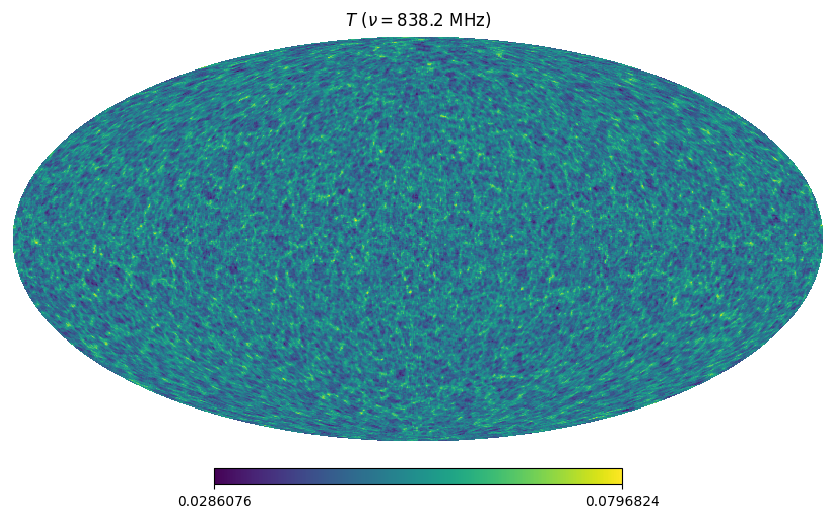

In [5]:


nu = 0.5*(nu_arr[0] + nu_arr[1])
imap = hp.read_map(f'{dirname_out}/colore_imap_s1_nu000.fits')
hp.mollview(imap, title='$T\\,\\,(\\nu = %.1lf\\,\\,{\\rm MHz})$' % nu)
print(imap)

# help(hp.pix2ang)


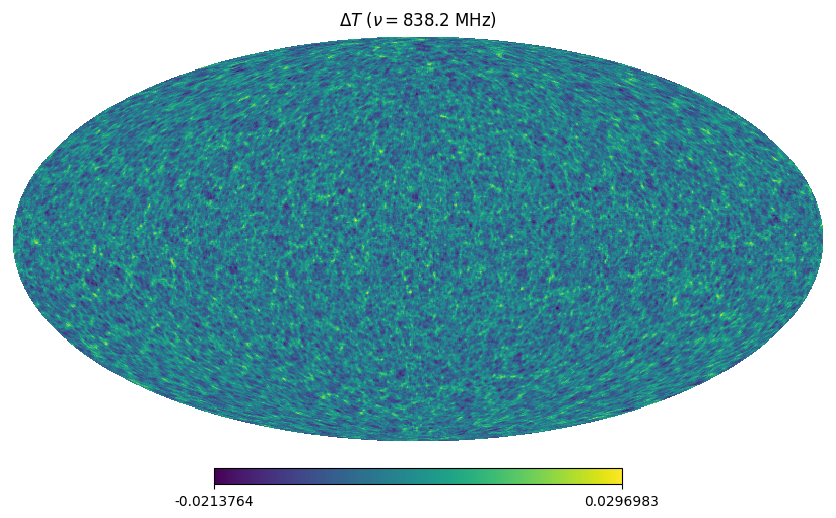

In [6]:
med_T=np.average(imap)
hp.mollview(imap-med_T, title='$\Delta T\\,\\,(\\nu = %.1lf\\,\\,{\\rm MHz})$' % nu)
#print(imap)

In [7]:
DeltaT=imap-med_T

# TreeCorr

In [8]:
from __future__ import print_function
import treecorr
import fitsio
import time
import pprint
import pandas as pd

nside = hp.get_nside(DeltaT)
npix = hp.get_map_size(DeltaT)

pixel_indices = np.arange(npix)
theta, phi = hp.pix2ang(nside, pixel_indices)
# phi is longitude (0 to 2π), theta is co-latitude (0 to π)
ra = np.degrees(phi)          # Right ascension in degrees
dec = 90.0 - np.degrees(theta) # Declination in degrees (convert from co-latitude)

intensity_values = DeltaT

catalog_imap = treecorr.Catalog(ra=ra, dec=dec, k=intensity_values, 
                          ra_units='deg', dec_units='deg')

print(f"Created catalog with {len(ra)} objects")
print(f"RA range: {ra.min():.2f} to {ra.max():.2f} deg")
print(f"Dec range: {dec.min():.2f} to {dec.max():.2f} deg")

Created catalog with 786432 objects
RA range: 0.00 to 359.82 deg
Dec range: -89.82 to 89.82 deg


In [9]:
kk = treecorr.KKCorrelation(min_sep=1, max_sep=10, nbins=100, sep_units='degrees')
#print('bin_size = %.6f'%gg.bin_size)

t1 = time.time()
kk.process(catalog_imap)  # Takes approx 1 minute / million objects
t2 = time.time()
print('Time for calculating kk correlation = ',t2-t1)

r = np.exp(kk.meanlogr)
xi = kk.xi
varxi = kk.varxi
#plt.errorbar(r[xi>0], xi[xi>0], yerr=varxi[xi>0])#, fmt='.')

Time for calculating kk correlation =  17.764262914657593


<ErrorbarContainer object of 3 artists>

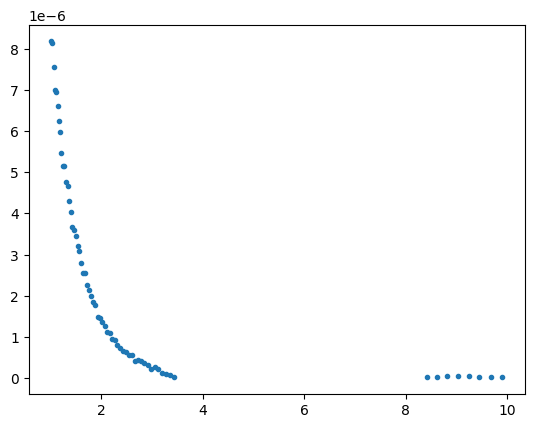

In [10]:
plt.errorbar(r[xi>0], xi[xi>0], yerr=varxi[xi>0], fmt='.')

# CAMB

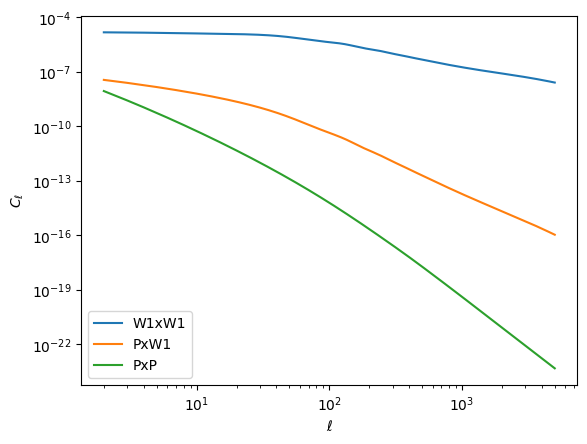

In [11]:
import camb
from camb import model
from camb.sources import SplinedSourceWindow
from scipy.special import erf

zs = np.arange(0.0, 1.5, 0.001)


def W_err(z,zc,sz,smooth):
    return (erf((zc+sz-z)/(np.sqrt(2)*smooth))-erf((zc-sz-z)/(np.sqrt(2)*smooth)))/2

# Get angular power spectrum for galaxy number counts and lensing
pars = camb.CAMBparams()
pars.set_cosmology(H0=H0, ombh2=Ob*h0**2, omch2=Ocdm*h0**2)
pars.InitPower.set_params(As=As, ns=ns)
lmax = 5000
pars.set_for_lmax(lmax, lens_potential_accuracy=1)

Ws=W_err(zs,0.7,0.1,0.01)

pars.Want_CMB = False
pars.NonLinear = model.NonLinear_both
pars.SourceWindows = [SplinedSourceWindow(z=zs, W=Ws, bias_z=np.ones(len(zs)))]

results = camb.get_results(pars)
cls = results.get_source_cls_dict(raw_cl=True)

# Note that P is CMB lensing, as a deflection angle power (i.e. PxP is [l(l+1)]^2C_l\phi\phi/2\pi)
# lensing window functions are for kappa (and counts for the fractional angular number density)
ls = np.arange(2, lmax + 1)
for spectrum in ["W1xW1", "PxW1", "PxP"]:
    plt.loglog(ls, cls[spectrum][2 : lmax + 1], label=spectrum)
plt.xlabel(r"$\ell$")
plt.ylabel(r"$C_\ell$")
plt.legend()


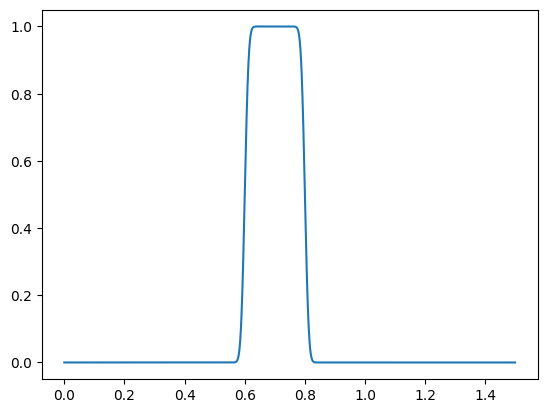

In [12]:
plt.plot(zs,Ws)

# CCL

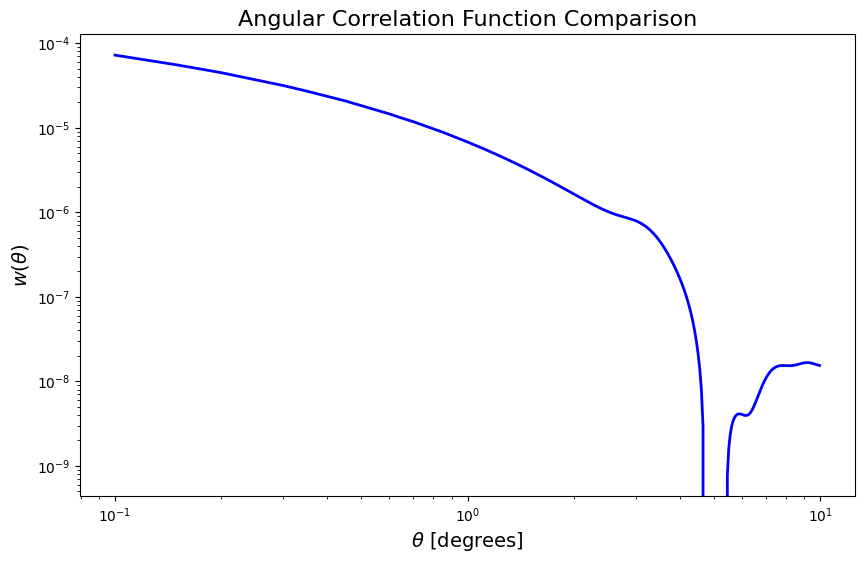

In [13]:
import pyccl as ccl

ell, C_ell = ls, cls['W1xW1'][2 : lmax + 1]

theta = np.arange(0.1, 10, 0.05)  # 0.01 to 10 degrees

wtheta = ccl.correlation(cosmo, ell=ell, C_ell=C_ell*0.05**2, 
                         theta=theta, type='NN')

plt.figure(figsize=(10, 6))
plt.loglog(theta, wtheta, 'b-', linewidth=2)

plt.xlabel(r'$\theta$ [degrees]', fontsize=14)
plt.ylabel(r'$w(\theta)$', fontsize=14)
plt.title('Angular Correlation Function Comparison', fontsize=16)
plt.show()

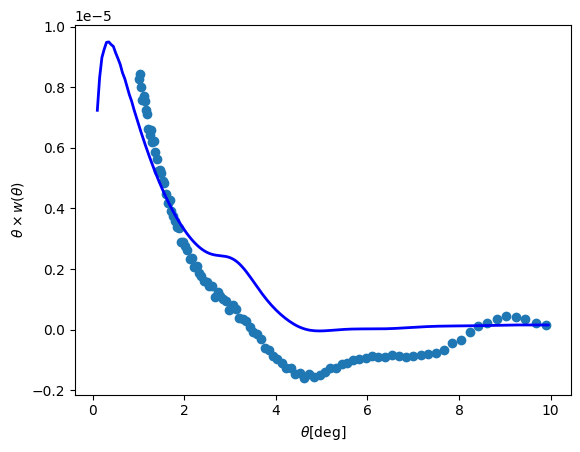

In [14]:
plt.plot(r, r*xi,'o',ls='',label='CoLoRe')
plt.plot(theta, theta*wtheta, 'b-', linewidth=2,)
plt.xlabel(r'$\theta [\deg]$')
plt.ylabel(r'$\theta\times w(\theta)$')
#plt.yscale('log')
plt.savefig('test_wtheta_HI.pdf')
plt.show()